In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.nn.functional import conv1d, pad
from torch.fft import fft
from torchaudio.transforms import FFTConvolve
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve

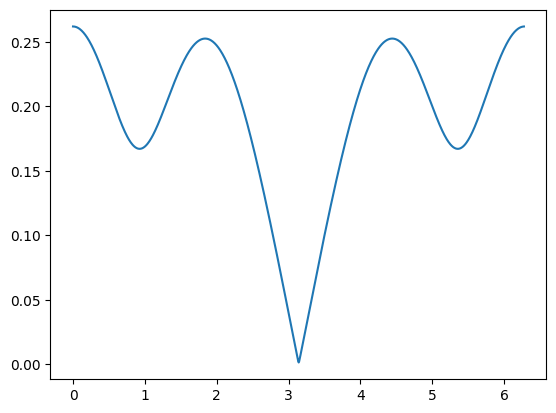

In [2]:
n = 5 # degree is n-1
N = 1000
a = (np.random.rand(n)*2-1) / n  # random polynomial of degree n-1 bounded above by 1

afunc = np.vectorize(lambda z: np.dot(a, np.power(z, np.arange(len(a)))))
thetas = 2*np.pi*np.arange(N)/N
zs = np.exp(1j*thetas)

plt.plot(thetas, np.abs(afunc(zs))) # plot the magnitude of the polynomial at the Nth roots of unity
plt.show()

In [11]:
def obj(a, b):
    delta = np.zeros(2*len(a)-1)
    delta[len(a)-1] = 1

    a_convolved = convolve(a, a[::-1], mode='full')
    b_convolved = convolve(b, b[::-1], mode='full')

    result = a_convolved + b_convolved - delta
    return np.linalg.norm(result, ord=2)**2

1.7593266476835467e-06


<Figure size 800x600 with 0 Axes>

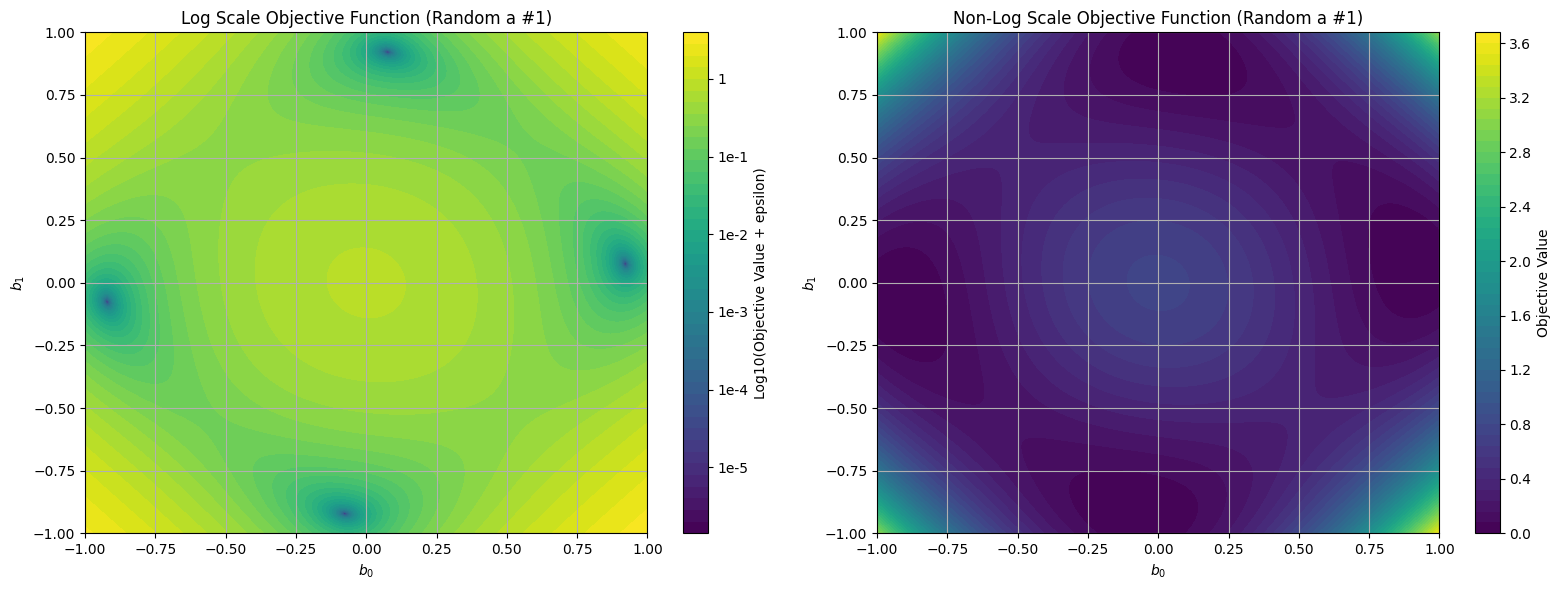

In [45]:

for k in range(1):
    # Select a random 'a' for n=2
    n = 2
    a = (np.random.rand(n) * 2 - 1) / n

    # Create a meshgrid of b values
    b0_values = np.linspace(-1, 1, 1000)
    b1_values = np.linspace(-1, 1, 1000)
    b0_grid, b1_grid = np.meshgrid(b0_values, b1_values)

    # Evaluate the obj(a, b) at each of these b values
    obj_values = np.zeros_like(b0_grid)

    b_grid = np.stack((b0_grid, b1_grid), axis=-1)
    obj_values = np.apply_along_axis(lambda b: obj(a, b), 2, b_grid)

    # Plot a color plot of the result
    plt.figure(figsize=(8, 6))
    
    # To avoid issues with log scale and zero values, add a small constant
    print(np.min(obj_values))
    epsilon = 1e-10
    obj_values_log = np.log10(obj_values + epsilon)
    
    # Create subplots for both log scale and non-log scale color bars
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot with logarithmic color scale
    contour_log = axs[0].contourf(b0_grid, b1_grid, obj_values_log, levels=50, cmap='viridis')
    cbar_log = plt.colorbar(contour_log, ax=axs[0], label='Log10(Objective Value + epsilon)')
    cbar_log.set_ticks(np.log10([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]))
    cbar_log.set_ticklabels(['1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1'])
    axs[0].set_xlabel(r'$b_0$')
    axs[0].set_ylabel(r'$b_1$')
    axs[0].set_title(f'Log Scale Objective Function (Random a #{k+1})')
    axs[0].grid(True)
    
    # Plot with non-logarithmic color scale
    contour_non_log = axs[1].contourf(b0_grid, b1_grid, obj_values, levels=50, cmap='viridis')
    cbar_non_log = plt.colorbar(contour_non_log, ax=axs[1], label='Objective Value')
    axs[1].set_xlabel(r'$b_0$')
    axs[1].set_ylabel(r'$b_1$')
    axs[1].set_title(f'Non-Log Scale Objective Function (Random a #{k+1})')
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()



In [14]:
n = 2
a = (np.random.rand(n) * 2 - 1) / n


def objective_torch(x, P):
    """
    Computes the loss for the optimization problem.

    This function calculates the loss as the squared norm of the difference
    between the target tensor P and the convolution of x with its flipped version.

    Parameters
    ----------
    x : torch.Tensor
        The input tensor for which the loss is computed.
    P : torch.Tensor
        The target tensor to compare against.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    x.requires_grad = True

    # Compute loss using squared distance function
    loss = torch.norm(P - FFTConvolve("full").forward(x, torch.flip(x, dims=[0])))**2
    return 1000*loss


def closure():
    """
    Closure function for the optimizer.

    This function zeroes the gradients, computes the loss using the objective_torch
    function, and performs backpropagation to compute the gradients.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    optimizer.zero_grad()
    loss = objective_torch(initial, conv_p_negative)
    loss.backward()
    return loss



# Generate a random polynomial on the specified device
poly = torch.tensor(a, dtype=torch.float32, device=device)

# Define the granularity for padding
granularity = 2 ** 25

# Pad the polynomial to match the granularity
P = pad(poly, (0, granularity - poly.shape[0]))

# Compute the negative convolution of the polynomial with its flipped version
conv_p_negative = FFTConvolve("full").forward(poly, torch.flip(poly, dims=[0])) * -1

# Adjust the last element to ensure the norm condition
conv_p_negative[poly.shape[0] - 1] = 1 - torch.norm(poly) ** 2

# Set up optimizer
initial = torch.randn(poly.shape[0], device=device, requires_grad=True)
initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)
optimizer = torch.optim.LBFGS([initial], max_iter=1000, line_search_fn="strong_wolfe", tolerance_grad=1e-10)

# Perform the optimization step using the closure function and record the time
t0 = time.time()
optimizer.step(closure)
t1 = time.time()
total = t1 - t0

print(f'N: {N}')
print(f'Time: {total}')
print(f'Final: {closure().item()}')
print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
print("-----------------------------------------------------")

N: 1000
Time: 0.07025504112243652
Final: 4.007905118896815e-11
# Iterations: 10
-----------------------------------------------------


In [15]:
foundb = optimizer._params[0].detach().cpu().numpy()

0.00023285475454460944


<Figure size 800x600 with 0 Axes>

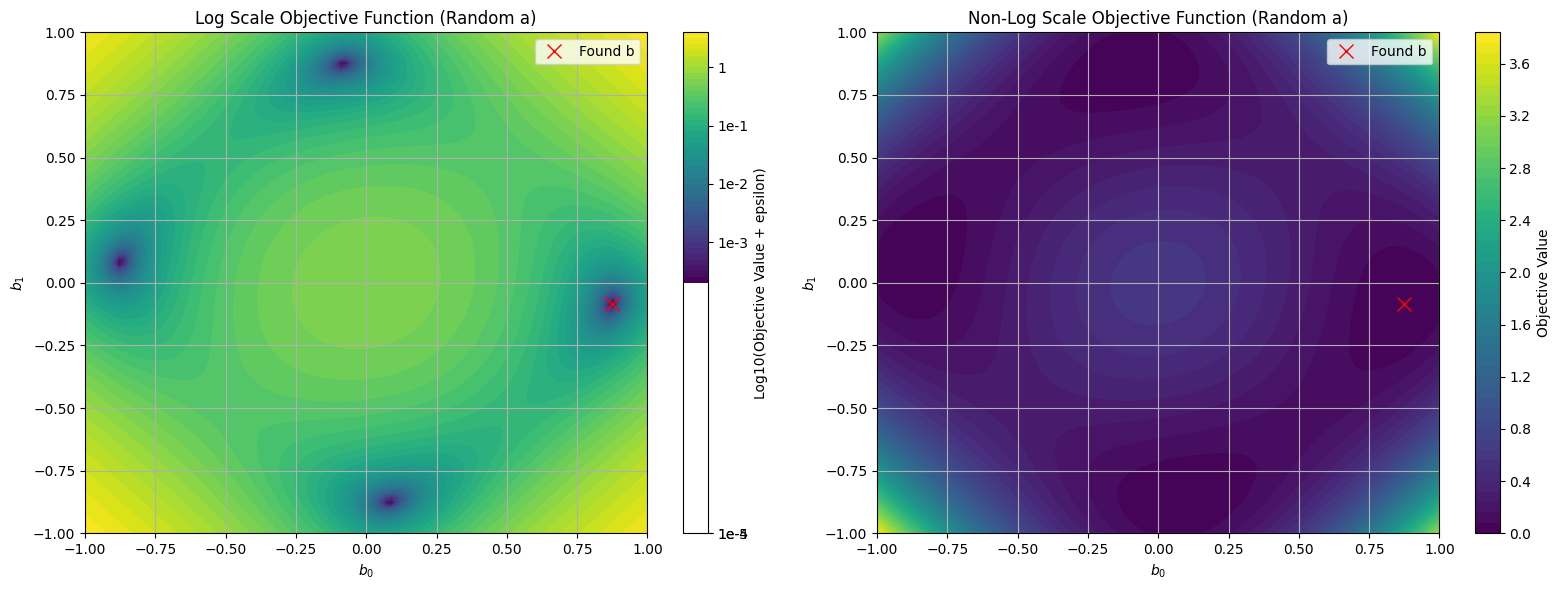

In [16]:
# Create a meshgrid of b values
b0_values = np.linspace(-1, 1, 100)
b1_values = np.linspace(-1, 1, 100)
b0_grid, b1_grid = np.meshgrid(b0_values, b1_values)

# Evaluate the obj(a, b) at each of these b values
obj_values = np.zeros_like(b0_grid)

b_grid = np.stack((b0_grid, b1_grid), axis=-1)
obj_values = np.apply_along_axis(lambda b: obj(a, b), 2, b_grid)

# Plot a color plot of the result
plt.figure(figsize=(8, 6))

# To avoid issues with log scale and zero values, add a small constant
print(np.min(obj_values))
epsilon = 1e-10
obj_values_log = np.log10(obj_values + epsilon)

# Create subplots for both log scale and non-log scale color bars
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot with logarithmic color scale
contour_log = axs[0].contourf(b0_grid, b1_grid, obj_values_log, levels=50, cmap='viridis')
cbar_log = plt.colorbar(contour_log, ax=axs[0], label='Log10(Objective Value + epsilon)')
cbar_log.set_ticks(np.log10([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]))
cbar_log.set_ticklabels(['1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1'])
axs[0].set_xlabel(r'$b_0$')
axs[0].set_ylabel(r'$b_1$')
axs[0].set_title(f'Log Scale Objective Function (Random a)')
axs[0].grid(True)
# Add a red x at the coordinates of foundb
axs[0].plot(foundb[0], foundb[1], 'rx', markersize=10, label='Found b')
axs[0].legend()

# Plot with non-logarithmic color scale
contour_non_log = axs[1].contourf(b0_grid, b1_grid, obj_values, levels=50, cmap='viridis')
cbar_non_log = plt.colorbar(contour_non_log, ax=axs[1], label='Objective Value')
axs[1].set_xlabel(r'$b_0$')
axs[1].set_ylabel(r'$b_1$')
axs[1].set_title(f'Non-Log Scale Objective Function (Random a)')
axs[1].grid(True)
# Add a red x at the coordinates of foundb
axs[1].plot(foundb[0], foundb[1], 'rx', markersize=10, label='Found b')
axs[1].legend()

plt.tight_layout()
plt.show()

In [19]:
from qsppack import nlfa

In [23]:
a = nlfa.weiss([0.1,0.1], 2**9)

In [25]:
n = 2


def objective_torch(x, P):
    """
    Computes the loss for the optimization problem.

    This function calculates the loss as the squared norm of the difference
    between the target tensor P and the convolution of x with its flipped version.

    Parameters
    ----------
    x : torch.Tensor
        The input tensor for which the loss is computed.
    P : torch.Tensor
        The target tensor to compare against.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    x.requires_grad = True

    # Compute loss using squared distance function
    loss = torch.norm(P - FFTConvolve("full").forward(x, torch.flip(x, dims=[0])))**2
    return 1000*loss


def closure():
    """
    Closure function for the optimizer.

    This function zeroes the gradients, computes the loss using the objective_torch
    function, and performs backpropagation to compute the gradients.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    optimizer.zero_grad()
    loss = objective_torch(initial, conv_p_negative)
    loss.backward()
    return loss



# Generate a random polynomial on the specified device
poly = torch.tensor(a, dtype=torch.float32, device=device)

# Define the granularity for padding
granularity = 2 ** 25

# Pad the polynomial to match the granularity
P = pad(poly, (0, granularity - poly.shape[0]))

# Compute the negative convolution of the polynomial with its flipped version
conv_p_negative = FFTConvolve("full").forward(poly, torch.flip(poly, dims=[0])) * -1

# Adjust the last element to ensure the norm condition
conv_p_negative[poly.shape[0] - 1] = 1 - torch.norm(poly) ** 2

# Set up optimizer
initial = torch.randn(poly.shape[0], device=device, requires_grad=True)
initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)
optimizer = torch.optim.LBFGS([initial], max_iter=1000, line_search_fn="strong_wolfe", tolerance_grad=1e-10)

# Perform the optimization step using the closure function and record the time
t0 = time.time()
optimizer.step(closure)
t1 = time.time()
total = t1 - t0

print(f'N: {N}')
print(f'Time: {total}')
print(f'Final: {closure().item()}')
print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
print("-----------------------------------------------------")

N: 1000
Time: 0.16427016258239746
Final: 7.758836906290867e-10
# Iterations: 21
-----------------------------------------------------


In [26]:
foundb = optimizer._params[0].detach().cpu().numpy()

3.9267912428687375e-07


<Figure size 800x600 with 0 Axes>

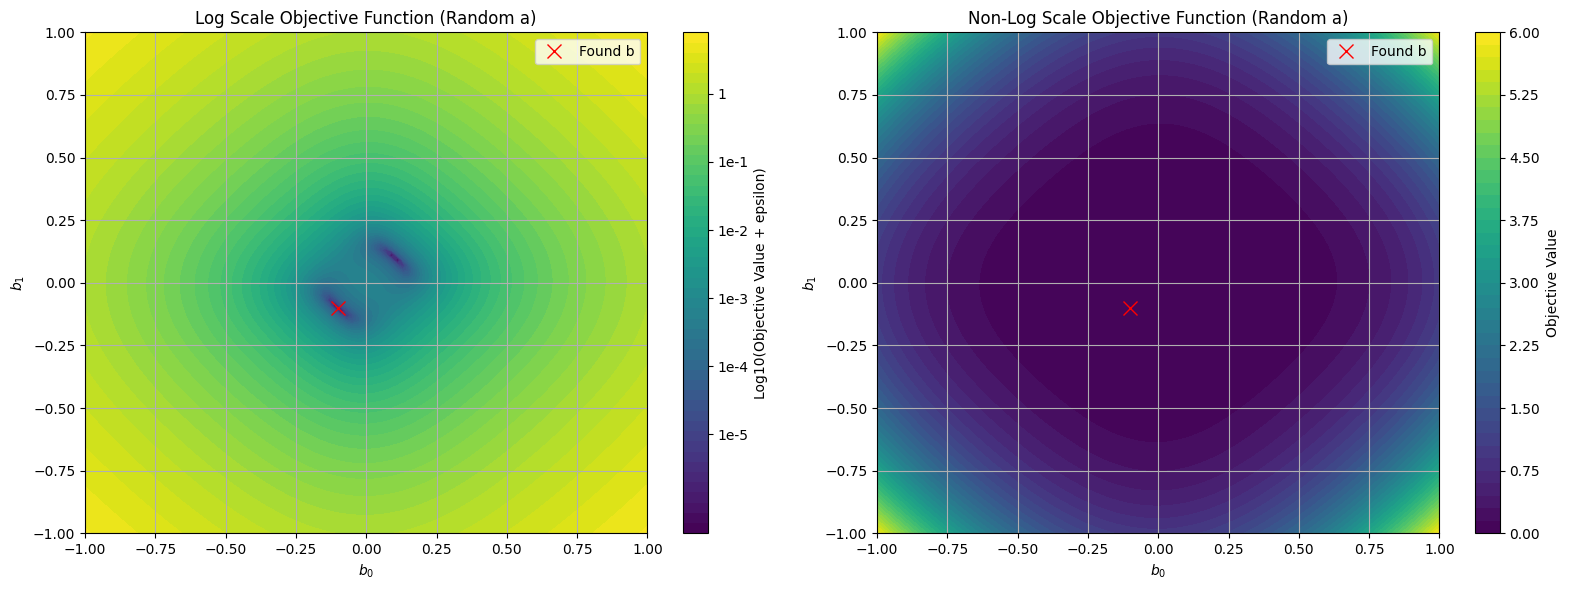

In [27]:
# Create a meshgrid of b values
b0_values = np.linspace(-1, 1, 100)
b1_values = np.linspace(-1, 1, 100)
b0_grid, b1_grid = np.meshgrid(b0_values, b1_values)

# Evaluate the obj(a, b) at each of these b values
obj_values = np.zeros_like(b0_grid)

b_grid = np.stack((b0_grid, b1_grid), axis=-1)
obj_values = np.apply_along_axis(lambda b: obj(a, b), 2, b_grid)

# Plot a color plot of the result
plt.figure(figsize=(8, 6))

# To avoid issues with log scale and zero values, add a small constant
print(np.min(obj_values))
epsilon = 1e-10
obj_values_log = np.log10(obj_values + epsilon)

# Create subplots for both log scale and non-log scale color bars
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot with logarithmic color scale
contour_log = axs[0].contourf(b0_grid, b1_grid, obj_values_log, levels=50, cmap='viridis')
cbar_log = plt.colorbar(contour_log, ax=axs[0], label='Log10(Objective Value + epsilon)')
cbar_log.set_ticks(np.log10([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]))
cbar_log.set_ticklabels(['1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1'])
axs[0].set_xlabel(r'$b_0$')
axs[0].set_ylabel(r'$b_1$')
axs[0].set_title(f'Log Scale Objective Function (Random a)')
axs[0].grid(True)
# Add a red x at the coordinates of foundb
axs[0].plot(foundb[0], foundb[1], 'rx', markersize=10, label='Found b')
axs[0].legend()

# Plot with non-logarithmic color scale
contour_non_log = axs[1].contourf(b0_grid, b1_grid, obj_values, levels=50, cmap='viridis')
cbar_non_log = plt.colorbar(contour_non_log, ax=axs[1], label='Objective Value')
axs[1].set_xlabel(r'$b_0$')
axs[1].set_ylabel(r'$b_1$')
axs[1].set_title(f'Non-Log Scale Objective Function (Random a)')
axs[1].grid(True)
# Add a red x at the coordinates of foundb
axs[1].plot(foundb[0], foundb[1], 'rx', markersize=10, label='Found b')
axs[1].legend()

plt.tight_layout()
plt.show()